In [1]:
import numpy as np
import os
import csv
import json
#
import matplotlib as mpl
import matplotlib.pyplot as plt
#
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

# Data Version

In [2]:
# data_version = 'S1_result_20210930_092146_LM2_v0.04_refinePoly_3'
# data_version = 'S6_result_20210929_162806_LM2_v0.04_refinePoly_3'
# data_version = 'S36_result_20210929_144813_LM2_v0.04_refinePoly_2'


# data_version = 'S1_result_20211007_134717_LM2_v0.04_refinePoly_FixGoldenP_FixYawB'
# data_version = 'S6_result_20211007_130048_LM2_v0.04_refinePoly_FixGoldenP_FixYawB'
# data_version = 'S36_result_20211007_120940_LM2_v0.04_refinePoly_FixGoldenP_FixYawB'

# data_version = 'S36_result_20211012_164919_alDMS_LM2_v0.05'
# data_version = 'S36_result_20211014_114532_alDMS_LM2_v0.05.1'


#
# data_version = 'S1_result_20211018_121724_FLD2_v0.05.6_256x256'
# data_version = 'S6_result_20211018_114210_alDMS_FLD2_v0.05.6_256x256'
# data_version = 'S36_result_20211018_111026_alDMS_FLD2_v0.05.6_256x256'

data_version = 'S36_c2x_result_20211019_122743_FLD2_v0.05.6_256x256'

Generate the path

In [3]:
path_root = '/home/benson516/m1_result_converter/'
video_version = data_version.split('_')[0]
print(video_version)

S36


In [4]:
if video_version == 'S1':
    csv_label_file = 'S1_eye_status_label_tri_state.csv'
    csv_predict_file = 'S1_GT-C0-001-L1-V1.10.csv'
elif video_version == 'S6':
    csv_label_file = 'S6_eye_status_label_tri_state.csv'
    csv_predict_file = 'S6_GT-C0-001-L1-V1.10.csv'
elif video_version == 'S36':
    csv_label_file = 'S36_eye_status_label_tri_state.csv'
    csv_predict_file = 'S36_GT-C1-001-L2-V1.10.csv'
else:
    csv_label_file = ''
    csv_predict_file = ''

In [5]:
# csv_label_root = os.path.join(path_root, data_version)
csv_label_root = path_root
csv_predict_root = os.path.join(path_root, data_version, 'converted_results')
#
csv_label_path = os.path.join(csv_label_root, csv_label_file)
csv_predict_path = os.path.join(csv_predict_root, csv_predict_file)
print(csv_label_path)
print(csv_predict_path)

/home/benson516/m1_result_converter/S36_eye_status_label_tri_state.csv
/home/benson516/m1_result_converter/S36_c2x_result_20211019_122743_FLD2_v0.05.6_256x256/converted_results/S36_GT-C1-001-L2-V1.10.csv


In [6]:
# Label
label_left_list = list()
label_right_list = list()
with open(csv_label_path) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # print(row["left"])
        label_left_list.append( int(row["left"]) )
        label_right_list.append( int(row["right"]) )
print(len(label_left_list))
print(len(label_right_list))

6389
6389


In [7]:
# Predict: eyeOpening
yv_left_list = list()
yv_right_list = list()
with open(csv_predict_path) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # int(row["frameNumber"])
        # print(row["headPositionAvailable"])
        # print(row["leftEyelidOpening"])
        try:
            yv_left_list.append(  float(row["leftEyelidOpening"]) )
        except:
            yv_left_list.append( 1.0 )
        try:
            yv_right_list.append( float(row["rightEyelidOpening"]) )
        except:
            yv_right_list.append( 1.0 )
print(len(yv_left_list))
print(len(yv_right_list))

6389
6389


In [8]:
# Filter the half-opening and Unknown class
keep_id_list_left  = [_idx for _idx in range(len(label_left_list)) if label_left_list[_idx] in (0,2) ]
keep_id_list_right = [_idx for _idx in range(len(label_right_list)) if label_right_list[_idx] in (0,2) ]
print(len(keep_id_list_left))
print(len(keep_id_list_right))

label_left_list  = [ _c for _idx, _c in enumerate(label_left_list) if _idx in keep_id_list_left]
yv_left_list     = [ _v for _idx, _v in enumerate(yv_left_list) if _idx in keep_id_list_left]
label_right_list = [ _c for _idx, _c in enumerate(label_right_list) if _idx in keep_id_list_right]
yv_right_list    = [ _v for _idx, _v in enumerate(yv_right_list) if _idx in keep_id_list_right]

6190
3892


In [9]:
label_left = np.array(label_left_list)
label_right = np.array(label_right_list)
yv_left = np.array(yv_left_list)
yv_right = np.array(yv_right_list)
#
mono_data_size = len(yv_left_list)

In [10]:
# Combine left and right
# label_class = np.array(label_left_list + label_right_list)
# Open
label_open = np.array(label_left_list + label_right_list) == 2
yv_opening = np.array(yv_left_list + yv_right_list)
# Close
lebel_close = np.array(label_left_list + label_right_list) == 0
yv_close = (-1) * np.array(yv_left_list + yv_right_list)

# Simple Prediction by Thresholding

In [11]:
# The threshold
v_threshold = 0.5 # 0.1 # 0.2 # 0.0 # 0.5 # 0.57 # 0.63 # 0.6 # 0.39

In [12]:
# Create class prediction
yc_open = (yv_opening > v_threshold)
yc_close = np.logical_not(yc_open)

In [13]:
# Positive: Open
confusion_matrix(label_open, yc_open)

array([[ 118,   23],
       [ 234, 9707]])

In [14]:
# Positive: Close
CM_close = confusion_matrix(lebel_close, yc_close)
print(CM_close)

[[9707  234]
 [  23  118]]


In [15]:
# P: close
TN = CM_close[0,0]
TP = CM_close[1,1]
FN = CM_close[1,0]
FP = CM_close[0,1]

In [16]:
precision_score(lebel_close, yc_close)

0.3352272727272727

In [17]:
recall_score(lebel_close, yc_close)

0.8368794326241135

In [18]:
# False Positive Rate (FPR)
FPR = FP / (FP + TN)
print(FPR)

0.02353887938839151


In [19]:
# Close: Find FN elements
FN_left_idx  = [_idx                    for _idx in range(lebel_close.shape[0]) if (lebel_close[_idx]) and (not yc_close[_idx]) and (_idx < mono_data_size)]
FN_right_idx = [(_idx - mono_data_size) for _idx in range(lebel_close.shape[0]) if (lebel_close[_idx]) and (not yc_close[_idx]) and (_idx >= mono_data_size)]
print(len(FN_left_idx))
print(FN_left_idx)
print(len(FN_right_idx))
print(FN_right_idx)

21
[629, 630, 1855, 1856, 3525, 5162, 5173, 5174, 5516, 5517, 5520, 5521, 5522, 5523, 5982, 5983, 6132, 6133, 6185, 6186, 6188]
2
[459, 622]


In [20]:
# Close: Find FP elements
FP_left_idx  = [_idx                    for _idx in range(lebel_close.shape[0]) if (not lebel_close[_idx]) and (yc_close[_idx]) and (_idx < mono_data_size)]
FP_right_idx = [(_idx - mono_data_size) for _idx in range(lebel_close.shape[0]) if (not lebel_close[_idx]) and (yc_close[_idx]) and (_idx >= mono_data_size)]
print(len(FP_left_idx))
print(FP_left_idx)
print(len(FP_right_idx))
print(FP_right_idx)

177
[134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 427, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 1951, 1952, 1955, 1957, 1958, 1961, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2012, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372, 2547, 2658, 2662, 2663, 2674, 2678, 2944, 4064, 4066, 4067, 4068, 4071, 4072, 4073, 4074, 4077, 4078, 4080, 4081, 4082, 4084, 4085, 4086, 4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097, 4098, 4099, 4109, 4114, 4115, 4116, 4118, 4125, 5579, 5580, 5581, 5994]
57
[

In [21]:
# Close: Find FP elements except the (class == 1) ones (half-open) and unknown one (class == -1)
FP_clear_left_idx  = [_idx for _idx in FP_left_idx if label_left[_idx] in (0,2) ]
FP_clear_right_idx = [_idx for _idx in FP_right_idx if label_right[_idx] in (0,2) ]
print(len(FP_clear_left_idx))
print(FP_clear_left_idx)
print(len(FP_clear_right_idx))
print(FP_clear_right_idx)

177
[134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 427, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 1951, 1952, 1955, 1957, 1958, 1961, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2012, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372, 2547, 2658, 2662, 2663, 2674, 2678, 2944, 4064, 4066, 4067, 4068, 4071, 4072, 4073, 4074, 4077, 4078, 4080, 4081, 4082, 4084, 4085, 4086, 4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097, 4098, 4099, 4109, 4114, 4115, 4116, 4118, 4125, 5579, 5580, 5581, 5994]
57
[

# Precision-recall Curve

In [22]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(lebel_close, yv_close)
neg_thresholds = -1.0 * thresholds

In [23]:
# target_recall = 0.9 # 0.94209 # 0.9 # 0.7
# precision_at_target = precisions[np.argmax(recalls <= target_recall)]
# threshold_at_target = thresholds[np.argmax(recalls <= target_recall)]
#
# target_idx = np.argmax(recalls <= precisions)
# print(target_idx)
# target_recall       = recalls[target_idx]
# precision_at_target = precisions[target_idx]
# threshold_at_target = thresholds[target_idx]
#
target_idx = np.argmax(neg_thresholds < 0.5)
print(target_idx)
target_recall       = recalls[target_idx]
precision_at_target = precisions[target_idx]
recall_at_target    = recalls[target_idx]
threshold_at_target = thresholds[target_idx]

2188


In [24]:
neg_threshold_at_target = -1.0 * threshold_at_target
print(precision_at_target)
print(recall_at_target)
print(neg_threshold_at_target)

0.3352272727272727
0.8368794326241135
0.4996


In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([min(thresholds[0], thresholds[-1]), max(thresholds[0], thresholds[-1]), 0, 1.05]) # Not shown

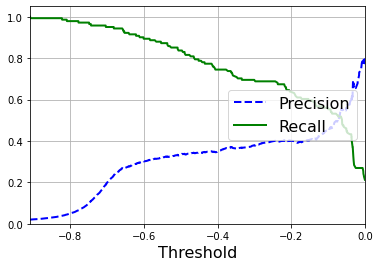

In [26]:
# Threshold for reversed scale
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
# plt.show()

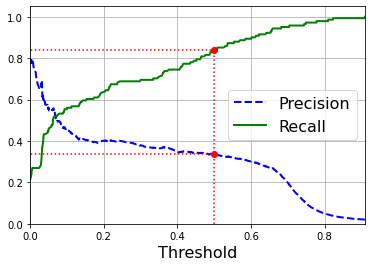

In [27]:
# Threshold for original scale
plot_precision_recall_vs_threshold(precisions, recalls, neg_thresholds)
#
plt.plot([neg_threshold_at_target, neg_threshold_at_target], [0., max(target_recall, precision_at_target)], "r:")
plt.plot([-5, neg_threshold_at_target], [target_recall, target_recall], "r:")             # Not shown
plt.plot([-5, neg_threshold_at_target], [precision_at_target, precision_at_target], "r:") # Not shown
plt.plot([neg_threshold_at_target], [target_recall], "ro")                                # Not shown
plt.plot([neg_threshold_at_target], [precision_at_target], "ro")                          # Not shown

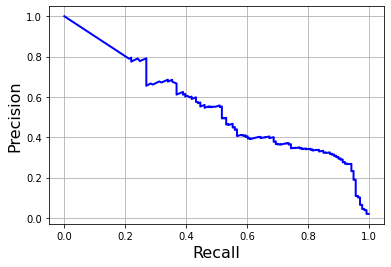

In [28]:
# plt.plot(recalls, precisions)

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)# Filter the half-opening and Unknown class
# keep_id_list_left  = [_idx for _idx in range(len(label_left_list)) if label_left_list[_idx] in (0,2) ]
# keep_id_list_right = [_idx for _idx in range(len(label_right_list)) if label_right_list[_idx] in (0,2) ]
# print(len(keep_id_list_left))
# print(len(keep_id_list_right))

# label_left_list  = [ _c for _idx, _c in enumerate(label_left_list) if _idx in keep_id_list_left]
# yv_left_list     = [ _v for _idx, _v in enumerate(yv_left_list) if _idx in keep_id_list_left]
# label_right_list = [ _c for _idx, _c in enumerate(label_right_list) if _idx in keep_id_list_right]
# yv_right_list    = [ _v for _idx, _v in enumerate(yv_right_list) if _idx in keep_id_list_right]
    plt.ylabel("Precision", fontsize=16)
    # plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
plot_precision_vs_recall(precisions, recalls)

# The ROC Curve

In [29]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(lebel_close, yv_close)

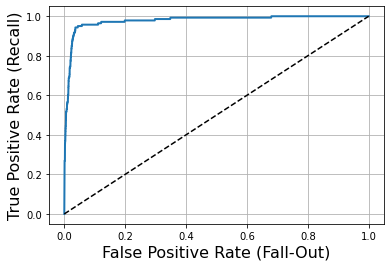

In [30]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    # plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown
    
plot_roc_curve(fpr, tpr)
plt.show()